# Tutorial 05 - Analyzing Gaze Velocity
In this tutorial we will look at how to calculate gaze velocity based on the `gaze_point_3d` data exported from Pupil Player.
We will follow these steps:
1. Load the data using `Pandas`.
1. Clean up 3d gaze point data
1. Convert the 3d gaze point data from cartesian coordinates to spherical coordinates
1. Calculate the gaze velocity in deg/sec
1. Visualize the gaze velocity over time

Please check the documentation of [Pupil Player](https://docs.pupil-labs.com/#pupil-player) to see how to export data.
This Notebook is accompanied by an example `gaze_positions.csv` which was already exported. You can find it in the `data/` subfolder. It includes 3d gaze data which is required for this tutorial!

## 1 - Loading Exported Data
Let's start by importing the necessary Python modules and loading the gaze exported data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(context="notebook", style="whitegrid", font_scale=1.2)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [5]:
exported_gaze_file = './drive/MyDrive/EyeTracking_HW/sample_recording_v2/exports/000/gaze_positions.csv'

In [6]:
exported_gaze = pd.read_csv(exported_gaze_file).dropna()
exported_gaze.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28196 entries, 0 to 31968
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gaze_timestamp    28196 non-null  float64
 1   world_index       28196 non-null  int64  
 2   confidence        28196 non-null  float64
 3   norm_pos_x        28196 non-null  float64
 4   norm_pos_y        28196 non-null  float64
 5   base_data         28196 non-null  object 
 6   gaze_point_3d_x   28196 non-null  float64
 7   gaze_point_3d_y   28196 non-null  float64
 8   gaze_point_3d_z   28196 non-null  float64
 9   eye_center0_3d_x  28196 non-null  float64
 10  eye_center0_3d_y  28196 non-null  float64
 11  eye_center0_3d_z  28196 non-null  float64
 12  gaze_normal0_x    28196 non-null  float64
 13  gaze_normal0_y    28196 non-null  float64
 14  gaze_normal0_z    28196 non-null  float64
 15  eye_center1_3d_x  28196 non-null  float64
 16  eye_center1_3d_y  28196 non-null  float64
 17

## 2 - Clean Up Of 3d Data
The depth of the gaze point can be estimated using vergence.

> "A vergence is the simultaneous movement of both eyes in opposite directions to obtain or maintain single binocular vision."
> - Cassin, B (1990). Dictionary of Eye Terminology. Solomon S. Gainesville, Fl: Triad Publishing Company. ISBN 978-0-937404-68-3.

Pupil looks for the point where the lines of sight of both eyes intersect or are closest to each other. Small errors in gaze direction estimation can lead to large errors in gaze depth estimation, especially if the subjects looks further than two meters. In these cases, the lines of sight are nearly parallel. In some cases, the calculated lines of sight do not converge in front of the subject but behind it. We "fix" this problem by flipping the z-component.

In [7]:
exported_gaze.gaze_point_3d_z
negative_z_mask = exported_gaze.gaze_point_3d_z < 0
negative_z_values = exported_gaze.loc[negative_z_mask,["gaze_point_3d_z"]]
exported_gaze.loc[negative_z_mask, ["gaze_point_3d_z"]] = negative_z_values * -1


## 3 - Conversion To Spherical Coordinates
In order to calculate the gaze velocity in degrees per second, we will have to convert the data from its cartesian coordinate system to a spherical coordinate system. Afterwards we plot the spherical coordinates over time and in space.

In [8]:
def cart_to_spherical(data, apply_rad2deg=False):
    # convert to spherical coordinates
    # source: http://stackoverflow.com/questions/4116658/faster-numpy-cartesian-to-spherical-coordinate-conversion
    x = data.gaze_point_3d_x
    y = data.gaze_point_3d_y
    z = data.gaze_point_3d_z
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arccos(y / r)  # for elevation angle defined from Z-axis down
    psi = np.arctan2(z, x)

    if apply_rad2deg:
        theta = np.rad2deg(theta)
        psi = np.rad2deg(psi)

    return r, theta, psi

def sphere_pos_over_time(ts, data, unit="radians"):
    for key, values in data.items():
        sns.lineplot(x=ts, y=values, label=key)
    plt.xlabel("time [sec]")
    plt.ylabel(unit)
    plt.legend()

def sphere_pos(r, theta, psi, unit="radians"):
    print(r.min(), r.max())
    norm = colors.LogNorm(vmin=r.min(), vmax=r.max())
    points = plt.scatter(
        theta,
        psi,
        c=r,
        alpha=0.5,
        cmap="cubehelix",
        norm=norm,
    )
    cbar = plt.colorbar(points)
    cbar.ax.set_ylabel("distance [mm]", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    plt.xlabel(f"theta [{unit[:3]}]")
    plt.ylabel(f"psi [{unit[:3]}]")

65.70788580999508 7581.311922444889


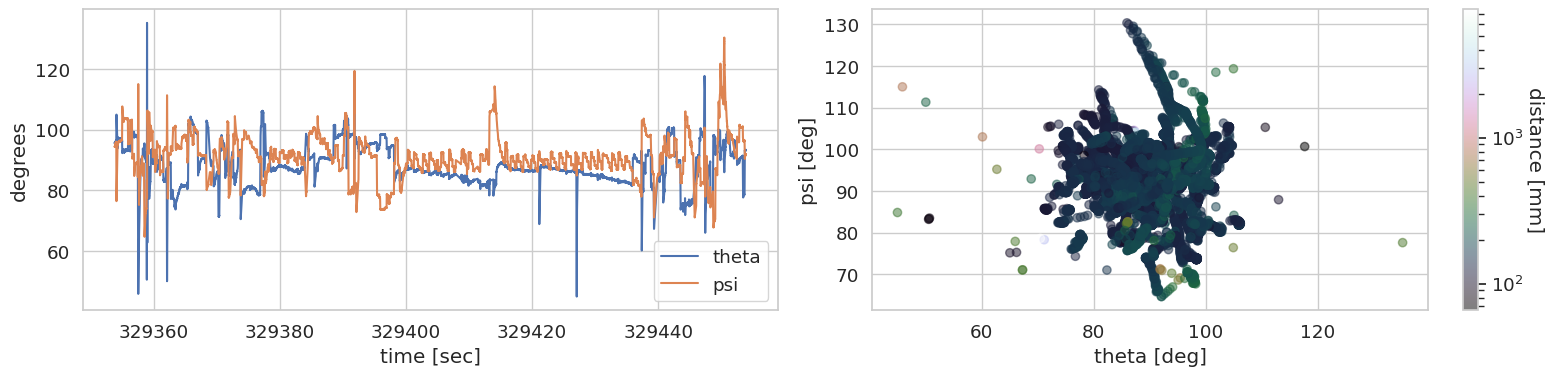

In [9]:
r, theta, psi = cart_to_spherical(exported_gaze, apply_rad2deg=True)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
sphere_pos_over_time(
    exported_gaze.gaze_timestamp,
    data={"theta": theta, "psi": psi},
    unit="degrees"
)

plt.subplot(1, 2, 2)
sphere_pos(r, theta, psi, unit="degrees")

plt.tight_layout()

## 4 - Calculating Gaze Velocity

In [10]:
squared_theta_diff = np.diff(theta) ** 2
squared_psi_diff = np.diff(psi) ** 2
deg_diff = np.sqrt(squared_theta_diff + squared_psi_diff)
ts_diff = np.diff(exported_gaze.gaze_timestamp)
deg_per_sec = deg_diff / ts_diff

## 5 - Visualizing  Gaze Velocity

Here we show how to visualize gaze velocity over time as well as the distribution of different velocities.

Text(0.5, 0, 'Gaze velocity [deg/sec]')

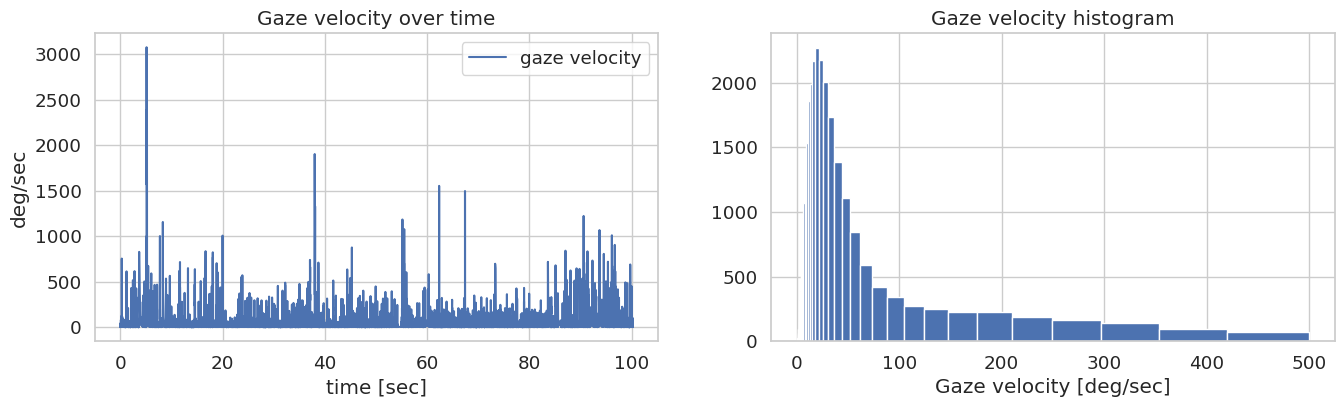

In [11]:

time = exported_gaze.gaze_timestamp[:-1] - exported_gaze.gaze_timestamp.iloc[0]

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
sphere_pos_over_time(time, {"gaze velocity": deg_per_sec}, unit="deg/sec")
plt.title("Gaze velocity over time")

plt.subplot(1, 2, 2)
plt.hist(deg_per_sec, bins=np.logspace(-1, np.log10(500), 50))
plt.title("Gaze velocity histogram")
plt.xlabel("Gaze velocity [deg/sec]")